# 1.概述

Bagging和Boosting都是分类器的集成算法。Bagging以并行方法集成算法，先构建一些小的分类器，然后基于每个分类器的结果做均值计算得到最终模型。Bagging方法因为其方差小，所以比单个分类器的效果更好。Boosting以串行方法集成，每个分类器顺序参与模型评估，并试图降低最终模型的偏差。Boosting方法的准确率较高，且鲁棒性较强。本文中，分别使用了RandomForest和XGBoost两种机器学习算法作为代表，对传统多因子模型进行分析和比较。两者都是基于决策树算法的延伸，前者基于Bagging方法，后者基于Boosting方法。具体的研究包括：
（1）特征数量对RandomForest和XGBoost预测能力的影响评价	
（2）	RandomForest和XGBoost的参数（模型复杂度）对于预测能力的影响评价
（3）	RandomForest和XGBoost的预测能力的评价
（4）	RandomForest和XGBoost的特征重要度

In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/19432
# 标题：基于随机森林和XGBoost的多因子模型分析

import pandas as pd
import numpy as np
import math
import jqdata
import time
import datetime
from jqfactor import standardlize
from jqfactor import winsorize_med
from jqfactor import get_factor_values
from jqfactor import neutralize
from sklearn.model_selection import StratifiedKFold, cross_val_score  # 导入交叉检验算法
from sklearn.feature_selection import SelectPercentile, f_classif  # 导入特征选择方法库
from sklearn.pipeline import Pipeline  # 导入Pipeline库
from sklearn.metrics import accuracy_score  # 准确率指标
from sklearn.metrics import roc_auc_score
from jqlib.technical_analysis import *
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

# 2. 数据获取和预处理

## 2.1 股票池设定

中证全指成分股。剔除ST股票，剔除每个截面期下一交易日停牌的股票，剔除上市3个月内的股票，每只股票视作一个样本。

In [4]:
#去除上市距beginDate不足n天的股票
def delete_stop(stocks,beginDate,n):
    stockList=[]
    beginDate = datetime.datetime.strptime(beginDate, "%Y-%m-%d")
    for stock in stocks:
        start_date=get_security_info(stock).start_date
        if start_date<(beginDate-datetime.timedelta(days=n)).date():
            stockList.append(stock)
    return stockList

In [25]:
#剔除ST股
def delete_st(stocks,begin_date):
    st_data=get_extras('is_st',stocks, count = 1,end_date=begin_date)
    stockList = [stock for stock in stocks if not st_data[stock][0]]
    return stockList

## 2.2 时间区间

2014年1月1日-2018年12月31日的5年区间。其中前4年区间（48个月）作为训练集，后1年区间（12个月）作为测试集。

In [6]:
#按月区间取值
peroid = 'M'
#样本区间（训练集+测试集的区间为2014-1-31到2018-12-31）
start_date = '2014-02-01'
end_date = '2019-01-31'
#训练集长度
train_length = 48
#聚宽一级行业
industry_code = ['HY001', 'HY002', 'HY003', 'HY004', 'HY005', 'HY006', 'HY007', 'HY008', 'HY009', 'HY010', 'HY011']

#股票池，获取中证全指
securities_list = delete_stop(get_index_stocks('000985.XSHG'),start_date,90)
securities_list = delete_st(securities_list,start_date)

## 2.3 特征和标签提取

每个自然月的最后一个交易日，计算因子暴露度，作为样本的原始特征；计算下期收益率，作为样本的标签

In [7]:
jqfactors_list = ['current_ratio',
                  'net_profit_to_total_operate_revenue_ttm',
                  'gross_income_ratio',
                  'roe_ttm',
                  'roa_ttm',
                  'total_asset_turnover_rate',\
                  'net_operating_cash_flow_coverage',
                  'net_operate_cash_flow_ttm',
                  'net_profit_ttm',\
                  'cash_to_current_liability',
                  'operating_revenue_growth_rate',
                  'non_recurring_gain_loss',\
                  'operating_revenue_ttm',
                  'net_profit_growth_rate']

In [8]:
def get_jq_factor(date):
    factor_data = get_factor_values(securities=securities_list, \
                                    factors=jqfactors_list, \
                                    count=1, \
                                    end_date=date)
    df_jq_factor=pd.DataFrame(index=securities_list)
    
    for i in factor_data.keys():
        df_jq_factor[i]=factor_data[i].iloc[0,:]
    
    return df_jq_factor

In [9]:
q = query(valuation.code, 
      valuation.market_cap,#市值
      valuation.circulating_market_cap,
      valuation.pe_ratio, #市盈率（TTM）
      valuation.pb_ratio, #市净率（TTM）
      valuation.pcf_ratio, #CFP
      valuation.ps_ratio, #PS
      balance.total_assets,
      balance.total_liability,
      balance.development_expenditure, #RD
      balance.dividend_payable,
      balance.fixed_assets,  
      balance.total_non_current_liability,
      income.operating_profit,
      income.total_profit, #OPTP
      #
      indicator.net_profit_to_total_revenue, #净利润/营业总收入
      indicator.inc_revenue_year_on_year,  #营业收入增长率（同比）
      indicator.inc_net_profit_year_on_year,#净利润增长率（同比）
      indicator.roe,
      indicator.roa,
      indicator.gross_profit_margin #销售毛利率GPM
    ).filter(
      valuation.code.in_(securities_list)
    )

In [10]:
#获取指定周期的日期列表 'W、M、Q'
def get_period_date(peroid,start_date, end_date):
    #设定转换周期period_type  转换为周是'W',月'M',季度线'Q',五分钟'5min',12天'12D'
    stock_data = get_price('000001.XSHE',start_date,end_date,'daily',fields=['close'])
    #记录每个周期中最后一个交易日
    stock_data['date']=stock_data.index
    #进行转换，周线的每个变量都等于那一周中最后一个交易日的变量值
    period_stock_data=stock_data.resample(peroid).last()
    date = period_stock_data.index
    pydate_array = date.to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array )
    date_only_series = pd.Series(date_only_array)
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    start_date = start_date-datetime.timedelta(days=1)
    start_date = start_date.strftime("%Y-%m-%d")
    date_list = date_only_series.values.tolist()
    date_list.insert(0,start_date)
    return date_list

In [11]:
def initialize_df(df,date):
    
    #净资产
    df['net_assets']=df['total_assets']-df['total_liability']

    df_new = pd.DataFrame(index=securities_list)
        
    #估值因子
    df_new['EP'] = df['pe_ratio'].apply(lambda x: 1/x)
    df_new['BP'] = df['pb_ratio'].apply(lambda x: 1/x)
    df_new['SP'] = df['ps_ratio'].apply(lambda x: 1/x)
    df_new['DP'] = df['dividend_payable']/(df['market_cap']*100000000)
    df_new['RD'] = df['development_expenditure']/(df['market_cap']*100000000)
    df_new['CFP'] = df['pcf_ratio'].apply(lambda x: 1/x)
    
    #杠杆因子
    #对数流通市值
    df_new['CMV'] = np.log(df['circulating_market_cap'])
    #总资产/净资产
    df_new['financial_leverage']=df['total_assets']/df['net_assets']
    #非流动负债/净资产
    df_new['debtequityratio']=df['total_non_current_liability']/df['net_assets']
    #现金比率=(货币资金+有价证券)÷流动负债
    df_new['cashratio']=df['cash_to_current_liability']
    #流动比率=流动资产/流动负债*100%
    df_new['currentratio']=df['current_ratio']
    
    #财务质量因子
    # 净利润与营业总收入之比
    df_new['NI'] = df['net_profit_to_total_operate_revenue_ttm']
    df_new['GPM'] = df['gross_income_ratio']
    df_new['ROE'] = df['roe_ttm']
    df_new['ROA'] = df['roa_ttm']
    df_new['asset_turnover'] = df['total_asset_turnover_rate']
    df_new['net_operating_cash_flow'] = df['net_operating_cash_flow_coverage']
    
    #成长因子
    df_new['Sales_G_q'] = df['operating_revenue_growth_rate']
    df_new['Profit_G_q'] = df['net_profit_growth_rate']
    
    #技术指标
    df_new['RSI']=pd.Series(RSI(securities_list, date, N1=20))    
    dif,dea,macd=MACD(securities_list, date, SHORT = 10, LONG = 30, MID = 15)
    df_new['DIF']=pd.Series(dif)
    df_new['DEA']=pd.Series(dea)
    df_new['MACD']=pd.Series(macd)    
    
    return df_new

In [12]:
dateList = get_period_date(peroid,start_date, end_date)

In [13]:
# (jqdata)因子
df_jq_factor = {}
# （财务数据）因子
df_q_factor = {}
# 预处理前的原始因子训练集
df_factor_pre_train = {}

for date in dateList:
    df_jq_factor = get_jq_factor(date)
    df_q_factor = get_fundamentals(q, date = date)
    df_q_factor.index = df_q_factor['code']
    # 合并得大表
    df_factor_pre_train[date] = pd.concat([df_q_factor,df_jq_factor],axis=1)
    # 初始化
    df_factor_pre_train[date] = initialize_df(df_factor_pre_train[date],date)

C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\ipykernel_launcher.py:10: SADeprecationWarning: Compiled objects now compile within the constructor.
  # Remove the CWD from sys.path while we load stuff.
C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\ipykernel_launcher.py:10: SADeprecationWarning: Compiled objects now compile within the constructor.
  # Remove the CWD from sys.path while we load stuff.
C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\ipykernel_launcher.py:10: SADeprecationWarning: Compiled objects now compile within the constructor.
  # Remove the CWD from sys.path while we load stuff.
C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\ipykernel_launcher.py:10: SADeprecationWarning: Compiled objects now compile within the constructor.
  # Remove the CWD from sys.path while we load stuff.
C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\ipykernel_launcher.py:10: SADeprecationWarning: Compiled objects now compile within the constructor.
  # Remove the CWD from sys.p

C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\ipykernel_launcher.py:10: SADeprecationWarning: Compiled objects now compile within the constructor.
  # Remove the CWD from sys.path while we load stuff.
C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\ipykernel_launcher.py:10: SADeprecationWarning: Compiled objects now compile within the constructor.
  # Remove the CWD from sys.path while we load stuff.
C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\ipykernel_launcher.py:10: SADeprecationWarning: Compiled objects now compile within the constructor.
  # Remove the CWD from sys.path while we load stuff.
C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\ipykernel_launcher.py:10: SADeprecationWarning: Compiled objects now compile within the constructor.
  # Remove the CWD from sys.path while we load stuff.
C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\ipykernel_launcher.py:10: SADeprecationWarning: Compiled objects now compile within the constructor.
  # Remove the CWD from sys.p

## 2.4	特征预处理

包括中位数去极值，缺失值处理，行业市值中性化，标准化等处理。

In [14]:
#取股票对应行业
def get_industry_name(i_Constituent_Stocks, value):
    return [k for k, v in i_Constituent_Stocks.items() if value in v]

In [15]:
#缺失值处理
def replace_nan_indu(factor_data,stockList,industry_code,date):
    #把nan用行业平均值代替，依然会有nan，此时用所有股票平均值代替
    i_Constituent_Stocks={}
    data_temp=pd.DataFrame(index=industry_code,columns=factor_data.columns)
    for i in industry_code:
        temp = get_industry_stocks(i, date)
        i_Constituent_Stocks[i] = list(set(temp).intersection(set(stockList)))
        data_temp.loc[i]=mean(factor_data.loc[i_Constituent_Stocks[i],:])
    for factor in data_temp.columns:
        #行业缺失值用所有行业平均值代替
        null_industry=list(data_temp.loc[pd.isnull(data_temp[factor]),factor].keys())
        for i in null_industry:
            data_temp.loc[i,factor]=mean(data_temp[factor])
        null_stock=list(factor_data.loc[pd.isnull(factor_data[factor]),factor].keys())
        for i in null_stock:
            industry=get_industry_name(i_Constituent_Stocks, i)
            if industry:
                factor_data.loc[i,factor]=data_temp.loc[industry[0],factor] 
            else:
                factor_data.loc[i,factor]=mean(factor_data[factor])
    return factor_data

In [16]:
#数据预处理
def data_preprocessing(factor_data,stockList,industry_code,date):
    #去极值
    factor_data=winsorize_med(factor_data, scale=5, inf2nan=False,axis=0)
    #缺失值处理
    factor_data=replace_nan_indu(factor_data,stockList,industry_code,date)
    #中性化处理
    factor_data=neutralize(factor_data, date=date, axis=0)
    #标准化处理
    factor_data=standardlize(factor_data,axis=0)
    
    return factor_data

In [17]:
# 预处理后的原始因子训练集
df_factor_train = {}

In [18]:
for date in dateList:
    df_factor_train[date] = data_preprocessing(df_factor_pre_train[date],securities_list,industry_code,date)

## 2.5	训练集和交叉验证集的合成

In [20]:
# 训练集数据
train_data=pd.DataFrame()
for date in dateList[:train_length]:
    traindf=df_factor_train[date]
    #stockList=list(traindf.index)
    #取收益率数据
    data_close=get_price(securities_list,date,dateList[dateList.index(date)+1],'1d','close')['close']
    traindf['pchg']=data_close.iloc[-1]/data_close.iloc[0]-1
    #剔除空值
    traindf=traindf.dropna()   
    #traindf=traindf.sort(columns='pchg')
    traindf=traindf.sort_values(by=['pchg'],ascending=False)
    #选取前后各30%的股票，剔除中间的噪声
    #取0-30%+70%-100%的数据
    traindf=traindf.iloc[:int(len(traindf['pchg'])/10*3),:].append(traindf.iloc[int(len(traindf['pchg'])/10*7):,:])
    #前30%为1，后30%为-1
    traindf['label']=list(traindf['pchg'].apply(lambda x:1 if x>np.mean(list(traindf['pchg'])) else -1))    
    if train_data.empty:
        train_data=traindf
    else:
        train_data=train_data.append(traindf)

C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\IPython\core\interactiveshell.py:3267: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
# 测试集数据        
test_data={}
for date in dateList[train_length:-1]:
    testdf=df_factor_train[date]
    stockList=list(testdf.index)
    # 取收益率数据
    data_close=get_price(stockList,date,dateList[dateList.index(date)+1],'1d','close')['close']
    testdf['pchg']=data_close.iloc[-1]/data_close.iloc[0]-1
    #剔除空值
    testdf=testdf.dropna()   
    testdf=testdf.sort_values(by=['pchg'],ascending=False)
    #选取前后各30%的股票，剔除中间的噪声
    #取0-30%+70%-100%的数据
    testdf=testdf.iloc[:int(len(traindf['pchg'])/10*3),:].append(testdf.iloc[int(len(testdf['pchg'])/10*7):,:])
    testdf['label']=list(testdf['pchg'].apply(lambda x:1 if x>np.mean(list(testdf['pchg'])) else -1)) 
    test_data[date]=testdf

In [22]:
y_train = train_data['label']  # 分割y
X_train = train_data.copy()
del X_train['pchg']
del X_train['label']

# 3.模型构建和样本内训练

通过Pipeline方法，将特征选择和模型构建结合起来，形成model_pipe对象，然后针对该对象做交叉验证并得到不同参数下的检验结果，辅助于最终模型的参数设置。

## 3.1 特征选择

本文用SelectPercentile（f_classif, percentile）来做特征选择，其中f_classif用来确定特征选择的得分标准，percentile用来确定特征选择的比例。

In [43]:
transform = SelectPercentile(f_classif)  # 使用f_classif方法选择特征最明显的?%数量的特征

#model = RandomForestClassifier()
model = XGBClassifier()
model_pipe = Pipeline(steps=[('ANOVA', transform), ('model', model)])  # 建立由特征选择和分类模型构成的“管道”对象

C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\JoinQuant-Desktop-Py3\Python\lib\site-package

C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\JoinQuant-Desktop-Py3\Python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\JoinQuant-Desktop-Py3\Python\lib\site-package

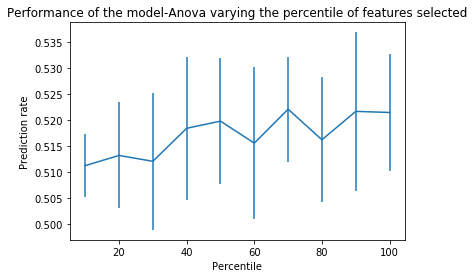

In [24]:
# 选择最佳特征比例
# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
for percentile in percentiles:
    model_pipe.set_params(ANOVA__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(model_pipe, X_train, y_train, cv=5, n_jobs=-1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title('Performance of the model-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')
plt.axis('tight')
plt.show()

由上述执行结果可知，随机森林的精度随着特征比例的上升而上升，而XGBoosting在特征比例为30%时最佳。结合效率，RandomForest和XGBoosting的最佳特征比例分别选择为80%和30%。

## 3.2 交叉验证调参

特征（比例）选择完成后，根据不同的参数（n_estimators,max_depth），对模型进行交叉验证。本文采用StratifiedKFold来将训练集分成训练集和验证集。StratifiedKFold能够有效结合分类样本标签做数据集分割，而不是完全的随机选择和分割。完成交叉验证后，选取交叉验证集AUC（或f1-score）最高的一组参数作为模型的最优参数。

In [44]:
transform = SelectPercentile(f_classif,percentile=80)  # 使用f_classif方法选择特征最明显的?%数量的特征

#model = RandomForestClassifier()
model = XGBClassifier()
model_pipe = Pipeline(steps=[('ANOVA', transform), ('model', model)])  # 建立由特征选择和分类模型构成的“管道”对象

In [51]:
cv = StratifiedKFold(5)  # 设置交叉检验次数
#RandomForest n_estimators
#parameters = [50, 100, 300, 500, 800]  # 设置模型参数列表#
#XGB/RandomForest max_depth
parameters = [3,4,5,6,7,8]
#XGB subsample
#parameters = [0.6,0.7,0.8,0.9,1]
#score_methods = ['roc_auc','accuracy', 'precision', 'recall', 'f1']  # 设置交叉检验指标
score_methods = ['roc_auc', 'f1']  # 设置交叉检验指标
#mean_list = list()  # 建立空列表用于存放不同参数方法、交叉检验评估指标的均值列表
#std_list = list()  # 建立空列表用于存放不同参数方法、交叉检验评估指标的标准差列表
for parameter in parameters:  # 循环读出每个参数值
    t1 = time.time()  # 记录训练开始的时间
    score_list = list()  # 建立空列表用于存放不同交叉检验下各个评估指标的详细数据
    print ('set parameters: %s' % parameter)  # 打印当前模型使用的参数
    for score_method in score_methods:  # 循环读出每个交叉检验指标
        #model_pipe.set_params(model__n_estimators=parameter)  # 通过“管道”设置分类模型参数
        model_pipe.set_params(model__max_depth=parameter)  # 通过“管道”设置分类模型参数            
        #model_pipe.set_params(model__subsample=parameter)  # 通过“管道”设置分类模型参数            
        score_tmp = cross_val_score(model_pipe, X_train, y_train, scoring=score_method, cv=cv, n_jobs=-1)  # 使用交叉检验计算指定指标的得分
        score_list.append(score_tmp)  # 将交叉检验得分存储到列表
    score_matrix = pd.DataFrame(np.array(score_list), index=score_methods)  # 将交叉检验详细数据转换为矩阵
    score_mean = score_matrix.mean(axis=1).rename('mean')  # 计算每个评估指标的均值
    score_std = score_matrix.std(axis=1).rename('std')  # 计算每个评估指标的标准差
    score_pd = pd.concat([score_matrix, score_mean, score_std], axis=1)  # 将原始详细数据和均值、标准差合并
    #mean_list.append(score_mean)  # 将每个参数得到的各指标均值追加到列表
    #std_list.append(score_std)  # 将每个参数得到的各指标标准差追加到列表
    print (score_pd.round(4))  # 打印每个参数得到的交叉检验指标数据，只保留4位小数
    print ('-' * 60)
    t2 = time.time()  # 计算每个参数下算法用时
    tt = t2 - t1  # 计算时间间隔
    print ('time: %s' % str(tt))  # 打印时间间隔

set parameters: 3
              0       1       2       3       4    mean     std
roc_auc  0.5769  0.5861  0.5746  0.5960  0.4826  0.5632  0.0459
f1       0.5830  0.5944  0.5951  0.5883  0.5219  0.5765  0.0310
------------------------------------------------------------
time: 190.25440001487732
set parameters: 4
              0       1       2       3       4    mean     std
roc_auc  0.5814  0.5856  0.5809  0.5974  0.4829  0.5657  0.0467
f1       0.5786  0.5881  0.5847  0.5838  0.5122  0.5695  0.0322
------------------------------------------------------------
time: 239.38179993629456
set parameters: 5
              0       1       2       3       4    mean     std
roc_auc  0.5850  0.5859  0.5839  0.5979  0.4829  0.5671  0.0474
f1       0.5773  0.5829  0.5742  0.5794  0.5011  0.5630  0.0348
------------------------------------------------------------
time: 286.11240005493164


## 3.3 模型构建

根据上述交叉验证的最优模型，分别使用随机森林和XGBoosting集成学习模型对训练集进行训练。

In [45]:
transform.fit(X_train, y_train)  # 应用特征选择对象选择要参与建模的特征变量
X_train_final = transform.transform(X_train)  # 获得具有显著性特征的特征变量

### 3.3.1 随机森林

(1)树颗数（n_estimators）
弱学习器（决策树）的个数称为树棵数(参数名为n_estimators)。一般来说如果树棵数太小，则无法发挥集成算法的优势而容易产生欠拟合；树棵数过大，会增大计算量，并且树棵数到一定的数量后，再增大树棵数获得的模型提升会很小，所以我们要寻找一个适中的数值。AUC、f1-scores随决策树棵数变化可参考表1所示。从表1可知增加决策树棵数的增加可以提升RandomForest模型的预测效果。考虑到其提升效果的边际效应，综合训练时间和效果提升考量，选取决策树棵数为500。

（2）分层数（max_depth）
max_depth用于降低每棵树的复杂度。max_depth参数的性能评价参考表所示。随着max_depth的上升，AUC表示不稳定，f1-score呈上升趋势，模型训练速度变慢。综合训练时间和效果提升考量，选取max_depth=4.

In [46]:
model = RandomForestClassifier(n_estimators=500,max_depth=4,random_state=0)
model.fit(X_train_final, y_train)  # 训练模型

time: 8.404559850692749


### 3.3.2 XGBoost

（1）subsample
subsample是训练集参与模型训练的比例，取值在0-1之间，可有效地防止过拟合。subsample参数的性能评价参考3.2执行结果所示。随着subsample的上升，f1-score呈下降趋势，模型训练速度加快，综合训练时间和效果提升考量，选取subsample=0.9。

（2）max_depth
max_depth参数的性能评价参考表所示。随着max_depth的上升，AUC和f1-score呈下降趋势，模型训练时间变慢。选取max_depth=1。

In [46]:
model = XGBClassifier(max_depth=1,subsample=0.9,random_state=0)
model.fit(X_train_final, y_train)  # 训练模型

time: 8.404559850692749


## 3.4 样本外测试

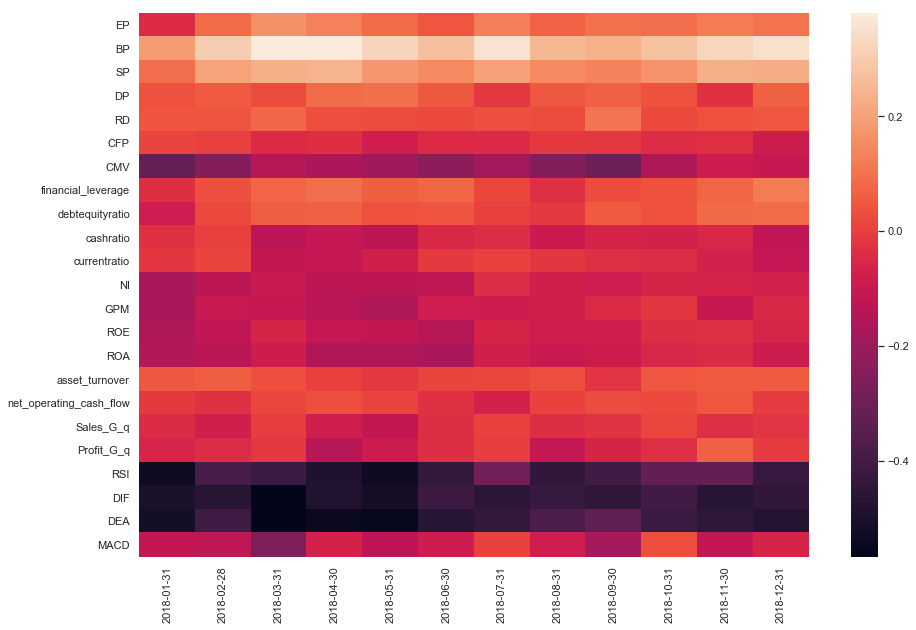

In [42]:
# 测试集特征相关度
factor_predict_corr=pd.DataFrame()

for date in dateList[train_length:-1]:
    test_feature=test_data[date].copy()
    del test_feature['pchg']
    del test_feature['label']
    test_feature['predict']=list(test_sample_predict[date])
    factor_predict_corr[date]=test_feature.corr()['predict']    
factor_predict_corr=factor_predict_corr.iloc[:-1]
# 高斯核 SVM 模型对于下期涨跌预测值与本期因子值之间相关系数示意图
#fig = plt.figure(figsize= (15,10))
ax = fig.add_subplot(111)
sns.set()
ax = sns.heatmap(factor_predict_corr)
#fig.savefig('C:\\Users\\Administrator\\Desktop\\corr.png')

In [47]:
test_sample_predict={}
test_sample_score=[]
test_sample_accuracy=[]
test_sample_roc_auc=[]
test_sample_date=[]

for date in dateList[train_length:-1]:
    # 取样本外数据特征及标签
    y_test=test_data[date]['label']
    X_test=test_data[date].copy()
    del X_test['pchg']
    del X_test['label']    
    # 新数据集做预测
    X_test_final = transform.transform(X_test)  # 对数据集做特征选择
    # 输出预测值以及预测概率
    y_pred_tmp = model.predict(X_test_final)
    y_pred = pd.DataFrame(y_pred_tmp, columns=['label_predict'])  # 获得预测标签
    y_pred_proba = pd.DataFrame(model.predict_proba(X_test_final), columns=['pro1', 'pro2'])  # 获得预测概率
    # 将预测标签、预测数据和原始数据X合并
    y_pred.set_index(X_test.index,inplace=True)
    y_pred_proba.set_index(X_test.index,inplace=True)
    predict_pd = pd.concat((X_test, y_pred, y_pred_proba), axis=1)
    print ('Predict date:')
    print (date)    
    print ('AUC:')
    print (roc_auc_score(y_test,y_pred))  # 打印前2条结果
    print ('Accuracy:')
    print (accuracy_score(y_test, y_pred))  # 打印前2条结果    
    print ('-' * 60)       
    ## 后续统计画图用
    test_sample_date.append(date)
    # 样本外预测结果
    test_sample_predict[date]=y_pred_tmp
    # 样本外准确率
    test_sample_accuracy.append(accuracy_score(y_test, y_pred))   
    # 样本外AUC值
    test_sample_roc_auc.append(roc_auc_score(y_test,y_pred))

print ('AUC mean info')
print (np.mean(test_sample_roc_auc))
print ('-' * 60)    
print ('ACCURACY mean info')
print (np.mean(test_sample_accuracy))
print ('-' * 60)    

Predict date:
2018-01-31
AUC:
0.4300806362225671
Accuracy:
0.4306306306306306
------------------------------------------------------------
Predict date:
2018-02-28
AUC:
0.5622402183551319
Accuracy:
0.5567567567567567
------------------------------------------------------------
Predict date:
2018-03-31
AUC:
0.5045652294391487
Accuracy:
0.5045045045045045
------------------------------------------------------------
Predict date:
2018-04-30
AUC:
0.5007100698293061
Accuracy:
0.5063063063063064
------------------------------------------------------------
Predict date:
2018-05-31
AUC:
0.48390739303923747
Accuracy:
0.4810810810810811
------------------------------------------------------------
Predict date:
2018-06-30
AUC:
0.5917825870095323
Accuracy:
0.5918918918918918
------------------------------------------------------------
Predict date:
2018-07-31
AUC:
0.47668892706716914
Accuracy:
0.47927927927927927
------------------------------------------------------------
Predict date:
2018-08-31

# 4.模型评价

## 4.1 预测能力

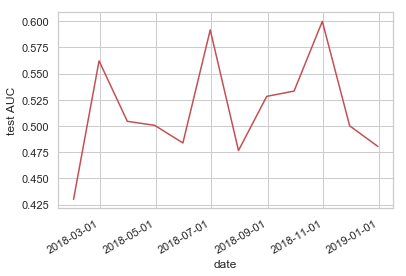

In [50]:
xs_date = [datetime.datetime.strptime(d, '%Y-%m-%d').date() for d in test_sample_date]
ys_auc = test_sample_roc_auc
# 配置横坐标
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(xs_date, ys_auc,'r')
# 自动旋转日期标记
plt.gcf().autofmt_xdate() 
# 横坐标标记
plt.xlabel('date')
# 纵坐标标记
plt.ylabel("test AUC")
plt.show()

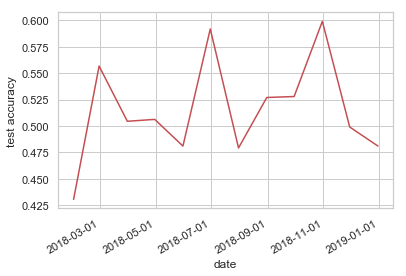

In [51]:
xs_date = [datetime.datetime.strptime(d, '%Y-%m-%d').date() for d in test_sample_date]
ys_score = test_sample_accuracy
# 配置横坐标
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(xs_date, ys_score,'r')
# 自动旋转日期标记
plt.gcf().autofmt_xdate() 
# 横坐标标记
plt.xlabel('date')
# 纵坐标标记
plt.ylabel("test accuracy")
plt.show()

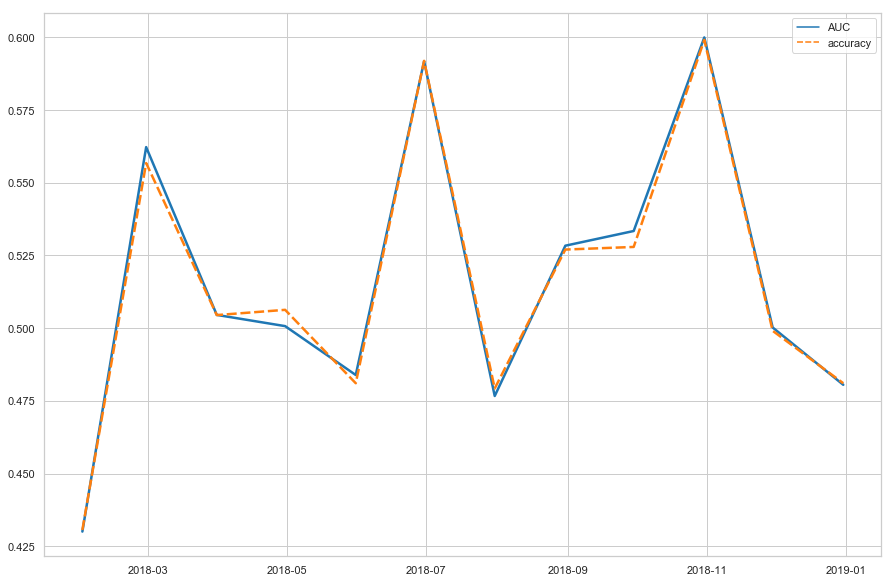

In [53]:
f = plt.figure(figsize= (15,10))

sns.set(style="whitegrid")
data1 = pd.DataFrame(ys_auc, xs_date, columns={'AUC'})
data2 = pd.DataFrame(ys_score, xs_date, columns={'accuracy'})
data = pd.concat([data1,data2],sort=False)
sns.lineplot(data=data, palette="tab10", linewidth=2.5)

## 4.2 特征重要度

In [58]:
#model = RandomForestClassifier(n_estimators=500,max_depth=4,random_state=0)
model = XGBClassifier(max_depth=1,subsample=0.9,random_state=0)
model.fit(X_train, y_train)  # 训练模型

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

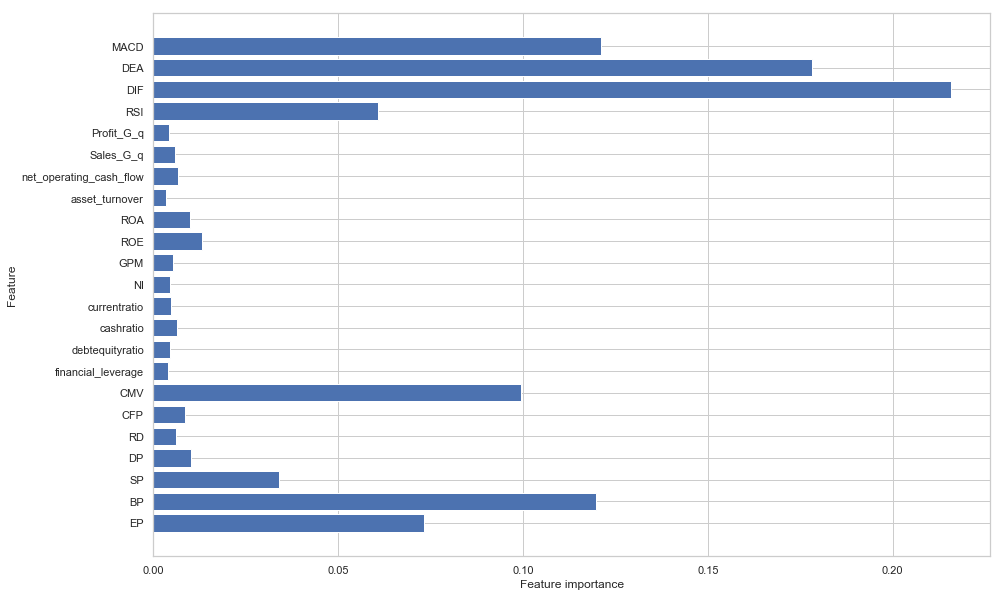

In [59]:
#%matplotlib inline
fig = plt.figure(figsize= (15,10))

n_features = X_train.shape[1]
plt.barh(range(n_features),model.feature_importances_,align='center')
plt.yticks(np.arange(n_features),X_train.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
#plt.savefig('C:\\Users\\Administrator\\Desktop\\rr-featureimport.png')